##### Step 1: Import Required Libraries and Ising Solvers

In [1]:
# Import the libraries and Ising Solvers from module
from Ising_Solvers import *

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


# Set a random seed
torch.manual_seed(42)

# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count() if torch.cuda.is_available() else 0
print(f"Using device: {device} (Number of GPUs: {num_gpus})")

# Set default dtype and device for optimization
torch.set_default_dtype(torch.float32)
if device.type == 'cuda':
    torch.set_default_device(device)

Using device: cpu (Number of GPUs: 0)


##### Step 2.1: Generate small Ising Model Data

In [2]:
# Function to build a small coupling matrix

n = 2000  # number of spins

# Generate K2000 Ising model data
J_mat = np.random.randn(n, n).astype(np.float32)
J_mat = torch.from_numpy(J_mat).to(device)
J_mat = (J_mat + J_mat.T) / 2  # Make symmetric
J_mat = torch.where(J_mat >= 0, torch.tensor(1.0, device=device), torch.tensor(-1.0, device=device))  # Binarize to +1/-1
J_mat.fill_diagonal_(0)  # No self-coupling


print('Computing matrix norms...')

# Compute required norms
J_mat_1_norm, j_mat_2_norm = compute_matrix_norms(J_mat)


print(f'Matrix 1-norm (max column sum): {J_mat_1_norm.item():.4f}')
print(f'Matrix 2-norm (spectral norm): {j_mat_2_norm.item():.4f}')

Computing matrix norms...
Matrix 1-norm (max column sum): 1999.0000
Matrix 2-norm (spectral norm): 89.4427


##### Step 2.2: Generate large Ising Model Data

In [3]:
# Function to build a large sparse coupling matrix using GPU acceleration

n = 10**5
sparsity = 0.99

tt = time.time()

J_mat = build_large_matrix(n, sparsity)


print(f'Total time taken: {time.time() - tt:.2f} seconds')

print('\n')

# calculate sparsity (ignore diagonal elements)
sparsity_r = 1 - J_mat.nnz / (n*(n-1))
print(f"Size: 10^{np.log10(n)} \nSparsity: {100*sparsity_r} %")



results = calculate_parameters_with_progress(J_mat, memory_efficient=True, chunk_size=10**4)

# store results in j_bar and J_torch_1_norm
j_bar = results['j_bar']
J_torch_1_norm = results['J_mat_1_norm']
j_mat_2_norm = results['j_mat_2_norm']

print(f'Generated large {n}x{n} symmetric coupling matrix')

CPU Memory: 30.47 GB
CPU Cores: 16
Matrix size: 100000 x 100000 = 10000000000 elements
Non-zero elements: ~100000000 (1.0000000000%)
Estimated memory (CSR format): ~0.56 GB
Available memory: 9.67 GB
Using 10 chunks with ~10000 rows per chunk
Will reduce non-zeros if memory usage exceeds 90%
Generating 100000x100000 sparse matrix with 99.0000000% sparsity
Using CSR format for memory efficiency

Processing chunk 0-10000 (10000 rows)
Row 9000/9999 - Memory: 70.7% used, 9.6GB freeeMemory: 70.8% used, 9.6GB free
Progress: 10.0% done, ~1.7 minutes remaining

Processing chunk 10000-20000 (10000 rows)
Row 19000/19999 - Memory: 73.4% used, 8.7GB freeMemory: 73.5% used, 8.7GB free
Progress: 20.0% done, ~1.5 minutes remaining

Processing chunk 20000-30000 (10000 rows)
Row 29000/29999 - Memory: 75.3% used, 8.1GB freeMemory: 75.8% used, 7.9GB free
Progress: 30.0% done, ~1.3 minutes remaining

Processing chunk 30000-40000 (10000 rows)
Row 39000/39999 - Memory: 78.0% used, 7.2GB freeMemory: 78.2% use

Summing squares: 100%|██████████| 198/198 [00:00<00:00, 4602.66chunk/s]

Converting to CSC format for column operations...


Calculating J_mat_1_norm...


Processing columns: 100%|██████████| 100/100 [00:00<00:00, 141.44chunk/s]

Calculating j_bar in chunks...
Generated large 100000x100000 symmetric coupling matrix


##### Step 3: Configure solver parameters

In [4]:
# Defaults for additional solvers
beta0_sa = 1.0  # initial inverse temperature for SA


c0_bsb = 0.5/(j_bar*np.sqrt(J_mat.shape[0]))
a0_bsb = 1.0
A_cim = 0.1
k_sis = 0.5
m_sis = 1.0
zeta0_sis = 0.05
beta0_sa = 1.0

print("Solver parameters configured.")

Solver parameters configured.


##### Step 4: Set Runtime Parameters

In [5]:
# Runtime and tuning parameters
max_run_time = 10      # seconds for main algorithm run
max_tune_time = 1     # seconds for parameter tuning
tune_res = 3            # rounds of tuning

# Initialize random starting point
x0 = torch.randn(n, device=device, dtype=torch.float32)

print(f'Algorithm parameters:')
print(f'  - Main runtime: {max_run_time} seconds')
print(f'  - Tuning time per trial: {max_tune_time} seconds')
print(f'  - Tuning rounds: {tune_res}')
print(f'  - Starting point initialized with {n} random values')

# Initialize solvers
doch_solver = DOCH(device)
adoch_solver = ADOCH(device)
sa_solver = SA(device)
bsb_solver = BSB(device)
simcim_solver = SimCIM(device)
sis_solver = SIS(device)
print('\nSolvers initialized successfully!')

Algorithm parameters:
  - Main runtime: 10 seconds
  - Tuning time per trial: 1 seconds
  - Tuning rounds: 3
  - Starting point initialized with 100000 random values

Solvers initialized successfully!


##### Step 5.1: DOCH Algorithm - Parameter Tuning

In [6]:
print("Tuning DOCH algorithm parameters...")

# Initial eta range for DOCH
Eta = np.linspace(0.1, 2, 10)

best_energy = 0
E_DOCH_best = []
T_DOCH_best = []
eta_DOCH = Eta[0]

for round_num in range(tune_res):
    print(f"\nTuning round {round_num + 1}/{tune_res}")

    for idx, eta in enumerate(Eta):
        # Test this eta value
        E_test, T_test, _ = doch_solver.solve(J_mat, x0, eta, j_mat_2_norm, J_mat_1_norm, max_tune_time)
        if len(E_test) == 0:
            continue

        if best_energy > E_test[-1] or (round_num == 0 and idx == 0):  # Lower energy is better
            best_energy = E_test[-1]
            eta_DOCH = eta
            best_idx = idx
            E_DOCH_best = E_test
            T_DOCH_best = T_test

    # Refine search around best eta
    if 'best_idx' not in locals():
        continue
    if best_idx == 0:
        Eta = np.linspace(max(Eta[best_idx]/2, 1e-3), Eta[best_idx], 10)
    elif best_idx == len(Eta)-1:
        Eta = np.linspace(Eta[best_idx], Eta[best_idx]*2, 10)
    else:
        Eta = np.linspace(Eta[best_idx-1], Eta[best_idx+1], 10)

    print(f'DOCH tuning round {round_num + 1}: tuned final Energy = {best_energy:.4f}')


Tuning DOCH algorithm parameters...

Tuning round 1/3
DOCH tuning round 1: tuned final Energy = -729068800.0000

Tuning round 2/3
DOCH tuning round 2: tuned final Energy = -730276480.0000

Tuning round 3/3
DOCH tuning round 3: tuned final Energy = -730784768.0000


##### Step 5.2: Run DOCH Algorithm

In [7]:
print("Running DOCH algorithm...")

start_time = time.time()
E_DOCH, T_DOCH, spins_DOCH = doch_solver.solve(J_mat, x0, eta_DOCH, j_mat_2_norm, J_mat_1_norm, max_run_time)
doch_runtime = time.time() - start_time

print(f"\nDOCH completed in {doch_runtime:.3f} seconds")
print(f"Final energy: {E_DOCH[-1]:.4f}")
print(f"Total iterations: {len(E_DOCH)}")

Running DOCH algorithm...
DOCH: 36 iter, 10.065s, Energy: -879016192.000
DOCH completed in 10.066 seconds
Final energy: -879016192.0000
Total iterations: 36


##### Step 6.1: ADOCH Algorithm - Parameter Tuning

In [8]:
print("Tuning ADOCH algorithm parameters...")

# ADOCH typically works better with smaller eta values
Eta = np.linspace(0.01, 0.2, 10)

best_energy = 0
E_ADOCH_best = []
T_ADOCH_best = []
eta_ADOCH = Eta[0]

for round_num in range(tune_res):
    print(f"\nTuning round {round_num + 1}/{tune_res}")

    for idx, eta in enumerate(Eta):
        # Test this eta value
        E_test, T_test, _ = adoch_solver.solve(J_mat, x0, eta, j_mat_2_norm, J_mat_1_norm, max_tune_time)

        if len(E_test) == 0:
            continue
        if best_energy > E_test[-1] or (round_num == 0 and idx == 0):  # Lower energy is better
            best_energy = E_test[-1]
            eta_ADOCH = eta
            best_idx = idx
            E_ADOCH_best = E_test
            T_ADOCH_best = T_test

    # Refine search around best eta
    if 'best_idx' not in locals():
        continue
    if best_idx == 0:
        Eta = np.linspace(max(Eta[best_idx]/2, 1e-3), Eta[best_idx], 10)
    elif best_idx == len(Eta)-1:
        Eta = np.linspace(Eta[best_idx], Eta[best_idx]*2, 10)
    else:
        Eta = np.linspace(Eta[best_idx-1], Eta[best_idx+1], 10)

    print(f'ADOCH tuning round {round_num + 1}: tuned final Energy = {best_energy:.4f}')


Tuning ADOCH algorithm parameters...

Tuning round 1/3
ADOCH tuning round 1: tuned final Energy = -535720448.0000

Tuning round 2/3
ADOCH tuning round 2: tuned final Energy = -827506944.0000

Tuning round 3/3
ADOCH tuning round 3: tuned final Energy = -843434048.0000


##### Step 6.2: Run ADOCH Algorithm

In [9]:
print("Running ADOCH algorithm...")

start_time = time.time()
E_ADOCH, T_ADOCH, spins_ADOCH = adoch_solver.solve(J_mat, x0, eta_ADOCH, j_mat_2_norm, J_mat_1_norm, max_run_time)
adoch_runtime = time.time() - start_time

print(f"\nADOCH completed in {adoch_runtime:.3f} seconds")
print(f"Final energy: {E_ADOCH[-1]:.4f}")
print(f"Total iterations: {len(E_ADOCH)}")

Running ADOCH algorithm...
ADOCH: 12 iter, 11.573s, Energy: -910341632.000
ADOCH completed in 11.573 seconds
Final energy: -910341632.0000
Total iterations: 12


##### Step 7.1: Tune parameters for other Solvers

In [10]:
print("Tuning parameters for SA, BSB, SimCIM, and SIS...")

# SA beta tuning
beta_candidates = np.linspace(1, 2, 10)
best_energy_sa = float('inf')
best_beta_sa = 1
E_SA_best = []
T_SA_best = []

for round_idx in range(tune_res):
    print(f"\nSA tuning round {round_idx + 1}/{tune_res}")
    best_idx_sa = None
    for idx, beta in enumerate(beta_candidates):
        E_test, T_test, _ = sa_solver.solve(J_mat, x0, beta, max_tune_time)
        if not E_test:
            continue
        final_energy = E_test[-1]
        if final_energy < best_energy_sa:
            best_energy_sa = final_energy
            best_beta_sa = beta
            best_idx_sa = idx
            E_SA_best = E_test
            T_SA_best = T_test
    if best_idx_sa is None:
        continue
    if best_idx_sa == 0:
        beta_candidates = np.linspace(max(beta_candidates[best_idx_sa] / 2, 0.1), beta_candidates[best_idx_sa], 10)
    elif best_idx_sa == len(beta_candidates) - 1:
        beta_candidates = np.linspace(beta_candidates[best_idx_sa], beta_candidates[best_idx_sa] * 2, 10)
    else:
        beta_candidates = np.linspace(beta_candidates[best_idx_sa - 1], beta_candidates[best_idx_sa + 1], 10)
    print(f"SA tuning round {round_idx + 1}: beta0 = {best_beta_sa:.4f}, energy = {best_energy_sa:.4f}")

beta0_sa = best_beta_sa

# BSB time-step tuning
dt_candidates = np.linspace(0.01, 0.1, 10)
best_energy_bsb = float('inf')
best_dt_bsb = 1
E_BSB_best = []
T_BSB_best = []

for round_idx in range(tune_res):
    print(f"\nBSB tuning round {round_idx + 1}/{tune_res}")
    best_idx_bsb = None
    for idx, dt in enumerate(dt_candidates):
        E_test, T_test, _ = bsb_solver.solve(J_mat, x0, a0_bsb, c0_bsb, dt, max_tune_time)
        if not E_test:
            continue
        final_energy = E_test[-1]
        if final_energy < best_energy_bsb:
            best_energy_bsb = final_energy
            best_dt_bsb = dt
            best_idx_bsb = idx
            E_BSB_best = E_test
            T_BSB_best = T_test
    if best_idx_bsb is None:
        continue
    if best_idx_bsb == 0:
        dt_candidates = np.linspace(max(dt_candidates[best_idx_bsb] / 2, 0.05), dt_candidates[best_idx_bsb], 10)
    elif best_idx_bsb == len(dt_candidates) - 1:
        dt_candidates = np.linspace(dt_candidates[best_idx_bsb], dt_candidates[best_idx_bsb] * 2, 10)
    else:
        dt_candidates = np.linspace(dt_candidates[best_idx_bsb - 1], dt_candidates[best_idx_bsb + 1], 10)
    print(f"BSB tuning round {round_idx + 1}: dt = {best_dt_bsb:.4f}, energy = {best_energy_bsb:.4f}")

dt_bsb = best_dt_bsb

# SimCIM time-step tuning
cim_candidates = np.linspace(0.01, 0.1, 10)
best_energy_cim = float('inf')
best_dt_cim = 1
E_CIM_best = []
T_CIM_best = []

for round_idx in range(tune_res):
    print(f"\nSimCIM tuning round {round_idx + 1}/{tune_res}")
    best_idx_cim = None
    for idx, dt in enumerate(cim_candidates):
        E_test, T_test, _ = simcim_solver.solve(J_mat, x0, A_cim, a0_bsb, c0_bsb, dt, max_tune_time)
        if not E_test:
            continue
        final_energy = E_test[-1]
        if final_energy < best_energy_cim:
            best_energy_cim = final_energy
            best_dt_cim = dt
            best_idx_cim = idx
            E_CIM_best = E_test
            T_CIM_best = T_test
    if best_idx_cim is None:
        continue
    if best_idx_cim == 0:
        cim_candidates = np.linspace(max(cim_candidates[best_idx_cim] / 2, 0.05), cim_candidates[best_idx_cim], 10)
    elif best_idx_cim == len(cim_candidates) - 1:
        cim_candidates = np.linspace(cim_candidates[best_idx_cim], cim_candidates[best_idx_cim] * 2, 10)
    else:
        cim_candidates = np.linspace(cim_candidates[best_idx_cim - 1], cim_candidates[best_idx_cim + 1], 10)
    print(f"SimCIM tuning round {round_idx + 1}: dt = {best_dt_cim:.4f}, energy = {best_energy_cim:.4f}")

dt_cim = best_dt_cim

# SIS delta_t tuning
sis_candidates = np.linspace(0.01, 0.1, 10)
best_energy_sis = float('inf')
best_dt_sis = 1
E_SIS_best = []
T_SIS_best = []

for round_idx in range(tune_res):
    print(f"\nSIS tuning round {round_idx + 1}/{tune_res}")
    best_idx_sis = None
    for idx, dt in enumerate(sis_candidates):
        E_test, T_test, _ = sis_solver.solve(J_mat, x0, m_sis, k_sis, zeta0_sis, dt, max_tune_time)
        if not E_test:
            continue
        final_energy = E_test[-1]
        if final_energy < best_energy_sis:
            best_energy_sis = final_energy
            best_dt_sis = dt
            best_idx_sis = idx
            E_SIS_best = E_test
            T_SIS_best = T_test
    if best_idx_sis is None:
        continue
    if best_idx_sis == 0:
        sis_candidates = np.linspace(max(sis_candidates[best_idx_sis] / 2, 0.05), sis_candidates[best_idx_sis], 10)
    elif best_idx_sis == len(sis_candidates) - 1:
        sis_candidates = np.linspace(sis_candidates[best_idx_sis], sis_candidates[best_idx_sis] * 2, 10)
    else:
        sis_candidates = np.linspace(sis_candidates[best_idx_sis - 1], sis_candidates[best_idx_sis + 1], 10)
    print(f"SIS tuning round {round_idx + 1}: dt = {best_dt_sis:.4f}, energy = {best_energy_sis:.4f}")

dt_sis = best_dt_sis

print("\nParameter tuning complete:")
print(f"  SA beta0: {beta0_sa:.4f}")
print(f"  BSB dt: {dt_bsb:.4f}")
print(f"  SimCIM dt: {dt_cim:.4f}")
print(f"  SIS dt: {dt_sis:.4f}")

Tuning parameters for SA, BSB, SimCIM, and SIS...

SA tuning round 1/3
SA tuning round 1: beta0 = 1.7778, energy = 7409960.0000

SA tuning round 2/3
SA tuning round 2: beta0 = 1.6667, energy = 7359294.0000

SA tuning round 3/3
SA tuning round 3: beta0 = 0.8333, energy = 7342244.0000

BSB tuning round 1/3
BSB tuning round 1: dt = 0.1000, energy = -530962252.0000

BSB tuning round 2/3
BSB tuning round 2: dt = 0.2000, energy = -684361980.0000

BSB tuning round 3/3
BSB tuning round 3: dt = 0.2222, energy = -698667738.0000

SimCIM tuning round 1/3
SimCIM tuning round 1: dt = 0.0300, energy = -676418900.0000

SimCIM tuning round 2/3
SimCIM tuning round 2: dt = 0.0333, energy = -679407820.0000

SimCIM tuning round 3/3
SimCIM tuning round 3: dt = 0.0331, energy = -681219422.0000

SIS tuning round 1/3
SIS tuning round 1: dt = 0.0800, energy = -585411154.0000

SIS tuning round 2/3
SIS tuning round 2: dt = 0.0744, energy = -587462534.0000

SIS tuning round 3/3

Parameter tuning complete:
  SA bet

##### Step 7.2: Run Solvers (SA, BSB, SimCIM, SIS)

In [ ]:
print("Running Solvers: SA, BSB, SimCIM, SIS...")

# SA
start_time = time.time()
E_SA, T_SA, spins_SA = sa_solver.solve(J_mat, x0, beta0_sa, max_run_time)
print(f"\nSA completed in {time.time()-start_time:.3f} seconds | final energy {E_SA[-1]:.4f}")

# BSB
start_time = time.time()
E_BSB, T_BSB, spins_BSB = bsb_solver.solve(J_mat, x0, a0_bsb, c0_bsb, dt_bsb, max_run_time)
print(f"\nBSB completed in {time.time()-start_time:.3f} seconds | final energy {E_BSB[-1]:.4f}")

# SimCIM
start_time = time.time()
E_CIM, T_CIM, spins_CIM = simcim_solver.solve(J_mat, x0, A_cim, a0_bsb, c0_bsb, dt_cim, max_run_time)
print(f"\nSimCIM completed in {time.time()-start_time:.3f} seconds | final energy {E_CIM[-1]:.4f}")

# SIS
start_time = time.time()
E_SIS, T_SIS, spins_SIS = sis_solver.solve(J_mat, x0, m_sis, k_sis, zeta0_sis, dt_sis, max_run_time)
print(f"\nSIS completed in {time.time()-start_time:.3f} seconds | final energy {E_SIS[-1]:.4f}")

Running Solvers: SA, BSB, SimCIM, SIS...

SA completed in 10.266 seconds | final energy -1362606.0000

BSB completed in 10.407 seconds | final energy -872057840.0000

SimCIM completed in 10.085 seconds | final energy -838268526.0000

SIS completed in 10.006 seconds | final energy -860304218.0000


##### Step 8: Compare Results

(The sparse matrix multiplication in PyTorch, used for speedup, involves randomization, so results may vary even with fixed seeds. Run it multiple times to observe differences.)

In [23]:
print("ALGORITHM COMPARISON RESULTS")
print("=" * 28)

print(f"Problem size: {n} spins")
print(f"Runtime per algorithm: {max_run_time} seconds")
print("\nFinal Results:")
print(f"  DOCH  final energy: {E_DOCH[-1]:.6f}")
print(f"  ADOCH final energy: {E_ADOCH[-1]:.6f}")
if 'E_SA' in globals() and len(E_SA) > 0:
    print(f"  SA    final energy: {E_SA[-1]:.6f}")
if 'E_BSB' in globals() and len(E_BSB) > 0:
    print(f"  BSB   final energy: {E_BSB[-1]:.6f}")
if 'E_CIM' in globals() and len(E_CIM) > 0:
    print(f"  SimCIM final energy: {E_CIM[-1]:.6f}")
if 'E_SIS' in globals() and len(E_SIS) > 0:
    print(f"  SIS   final energy: {E_SIS[-1]:.6f}")

print(f"\nConvergence Analysis:")
print(f"  DOCH  iterations: {len(E_DOCH)}")
print(f"  ADOCH iterations: {len(E_ADOCH)}")
if 'E_SA' in globals():
    print(f"  SA    iterations: {len(E_SA)}")
if 'E_BSB' in globals():
    print(f"  BSB   iterations: {len(E_BSB)}")
if 'E_CIM' in globals():
    print(f"  SimCIM iterations: {len(E_CIM)}")
if 'E_SIS' in globals():
    print(f"  SIS   iterations: {len(E_SIS)}")

# Prepare data for bar plots
labels = ['DOCH', 'ADOCH']
energies = [E_DOCH[-1], E_ADOCH[-1]]
iters = [len(E_DOCH), len(E_ADOCH)]
if 'E_SA' in globals() and len(E_SA) > 0:
    labels.append('SA'); energies.append(E_SA[-1]); iters.append(len(E_SA))
if 'E_BSB' in globals() and len(E_BSB) > 0:
    labels.append('BSB'); energies.append(E_BSB[-1]); iters.append(len(E_BSB))
if 'E_CIM' in globals() and len(E_CIM) > 0:
    labels.append('SimCIM'); energies.append(E_CIM[-1]); iters.append(len(E_CIM))
if 'E_SIS' in globals() and len(E_SIS) > 0:
    labels.append('SIS'); energies.append(E_SIS[-1]); iters.append(len(E_SIS))



ALGORITHM COMPARISON RESULTS
Problem size: 100000 spins
Runtime per algorithm: 10 seconds

Final Results:
  DOCH  final energy: -879016192.000000
  ADOCH final energy: -910341632.000000
  SA    final energy: -1362606.000000
  BSB   final energy: -872057840.000000
  SimCIM final energy: -838268526.000000
  SIS   final energy: -860304218.000000

Convergence Analysis:
  DOCH  iterations: 36
  ADOCH iterations: 12
  SA    iterations: 73
  BSB   iterations: 25
  SimCIM iterations: 24
  SIS   iterations: 24


##### Step 9: Plot Results

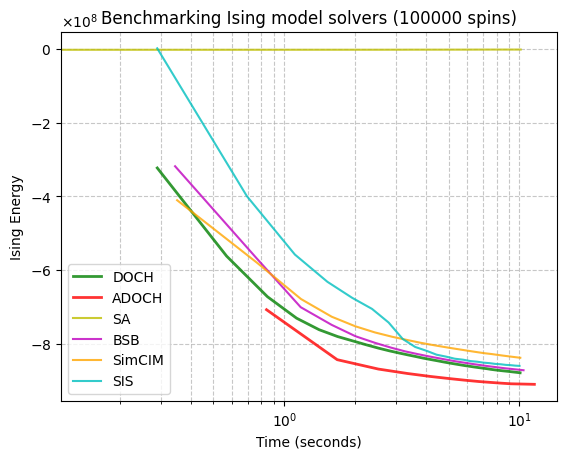

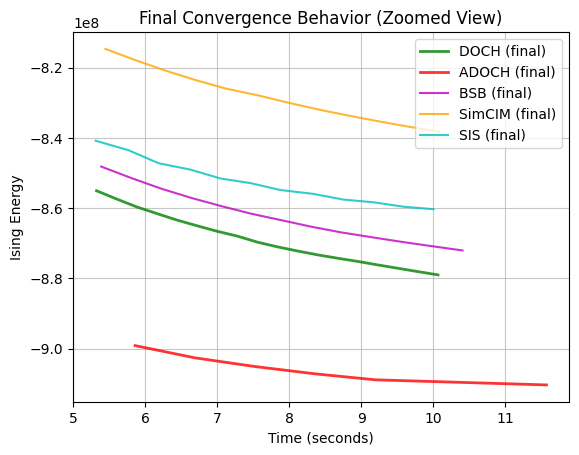

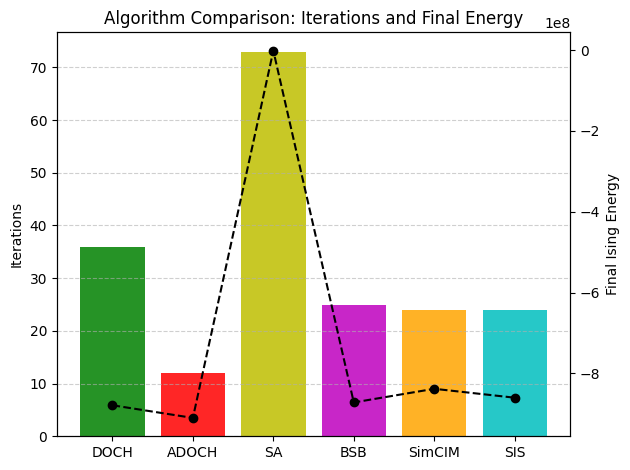

In [24]:
# Main convergence plot
plt.figure()
plt.plot(T_DOCH, E_DOCH, label='DOCH', color='green', linewidth=2, alpha=0.8)
plt.plot(T_ADOCH, E_ADOCH, label='ADOCH', color='red', linewidth=2, alpha=0.8)
if 'T_SA' in globals():
    plt.plot(T_SA, E_SA, label='SA', color='y', linewidth=1.5, alpha=0.8)
if 'T_BSB' in globals():
    plt.plot(T_BSB, E_BSB, label='BSB', color='m', linewidth=1.5, alpha=0.8)
if 'T_CIM' in globals():
    plt.plot(T_CIM, E_CIM, label='SimCIM', color='orange', linewidth=1.5, alpha=0.8)
if 'T_SIS' in globals():
    plt.plot(T_SIS, E_SIS, label='SIS', color='c', linewidth=1.5, alpha=0.8)

plt.xscale('log')
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Ising Energy')
plt.title(f'Benchmarking Ising model solvers ({n} spins)')
plt.legend(fontsize=10)

# Format y-axis for scientific notation
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
plt.gca().yaxis.set_major_formatter(formatter)

# Zoomed view of the final convergence 
plt.figure()
# Show last 50% of the convergence
if len(T_DOCH) > 1:
    doch_start = len(T_DOCH) // 2
    plt.plot(T_DOCH[doch_start:], E_DOCH[doch_start:], label='DOCH (final)', color='green', linewidth=2, alpha=0.8)
if len(T_ADOCH) > 1:
    adoch_start = len(T_ADOCH) // 2
    plt.plot(T_ADOCH[adoch_start:], E_ADOCH[adoch_start:], label='ADOCH (final)', color='red', linewidth=2, alpha=0.8)
# if 'T_SA' in globals() and len(T_SA) > 1:
#     sa_start = len(T_SA) // 2
#     plt.plot(T_SA[sa_start:], E_SA[sa_start:], label='SA (final)', color='y', linewidth=1.5, alpha=0.8)
if 'T_BSB' in globals() and len(T_BSB) > 1:
    bsb_start = len(T_BSB) // 2
    plt.plot(T_BSB[bsb_start:], E_BSB[bsb_start:], label='BSB (final)', color='m', linewidth=1.5, alpha=0.8)
if 'T_CIM' in globals() and len(T_CIM) > 1:
    cim_start = len(T_CIM) // 2
    plt.plot(T_CIM[cim_start:], E_CIM[cim_start:], label='SimCIM (final)', color='orange', linewidth=1.5, alpha=0.8)
if 'T_SIS' in globals() and len(T_SIS) > 1:
    sis_start = len(T_SIS) // 2
    plt.plot(T_SIS[sis_start:], E_SIS[sis_start:], label='SIS (final)', color='c', linewidth=1.5, alpha=0.8)

plt.grid(True, alpha=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Ising Energy')
plt.title('Final Convergence Behavior (Zoomed View)', fontsize=12)
plt.legend()


# iterations and final energy plot
fig, ax1 = plt.subplots()

color_map = {'DOCH': 'green', 'ADOCH': 'red', 'SA': 'y', 'BSB': 'm', 'SimCIM': 'orange', 'SIS': 'c'}
colors = [color_map.get(lbl, 'tab:blue') for lbl in labels]
x = np.arange(len(labels))

# Plot iterations on primary y-axis
bars1 = ax1.bar(x, iters, color=colors, alpha=0.85)
ax1.set_ylabel('Iterations')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_title('Algorithm Comparison: Iterations and Final Energy')
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Create secondary y-axis for final energy
ax2 = ax1.twinx()
bars2 = ax2.plot(x, energies, color='black', marker='o', linestyle='--', label='Final Ising Energy')
ax2.set_ylabel('Final Ising Energy')

plt.tight_layout()
plt.show()